In [ ]:
# !pip install opencv-contrib-python==4.4.0.44

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix

In [ ]:
### defining some parameters.

class config:
    CDNN_SHAPE = (400, 400) ### the shape of input images for DCNN 
    TRAINING_SET_SIZE = 1100 ### number of training samples
    TESTING_SET_SIZE = 600 ### number of testing samples
    VALIDATION_SET_SIZE = 200 ### number of validation samples 
    N_CLUSTER = 50 ### NUMBER OF VISUAL WORDS  *OR*  NUMBER OF FEATURES  *OR*  number of clusters

In [ ]:
path_dataset = '/content/drive/MyDrive/projects/estee/NEW_DATASET'

b_images = os.listdir(path_dataset+'/BONAFIDEA') ### get all of `bonafide` files name
m_images = os.listdir(path_dataset+'/morphed') ### get all of `morphed` files name

print(f'number of Bonafide images: {len(b_images)}\nnumber of Morphed images: {len(m_images)}')

number of Bonafide images: 920
number of Morphed images: 1066


In [ ]:
### creating a Pandas Dataframe with file name and class type (morphe/bonafide)

df_all = pd.DataFrame(b_images,columns=['file'])
df_all['class'] = 0
df_all_ = pd.DataFrame(m_images,columns=['file'])
df_all_['class'] = 1
df_all = pd.concat((df_all, df_all_),axis=0)

In [ ]:
### train test split. I used stratify to keep distribution of the whole dataset

X_train, X_test, y_train, y_test = train_test_split(df_all['file'].to_numpy(), 
                                                    df_all['class'].to_numpy(), 
                                                    test_size=0.33, 
                                                    random_state=1370,
                                                    stratify=df_all['class'])

## DCNN_ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101V2, InceptionV3, VGG19, EfficientNetB7
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical 


In [ ]:
### Data augmentation
from scipy.ndimage import rotate



def aug_rotate(img, angle, bg_patch=(5,5)):
    rgb = len(img.shape) == 3
    bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

def aug_gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)*255
    mask_overflow_upper = img+noise >= 255.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 255.0
    noise[mask_overflow_lower] = 0
    return img + noise.astype(int)


def aug_random_crop(img, crop_size=config.CDNN_SHAPE):
    img = img.copy()
    w, h = img.shape[:2]
    x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
    img = img[y:y+crop_size[0], x:x+crop_size[1]]
    return img



In [ ]:
### to avoid loading all images at once, I used Batch generator technique.
### in each step of each epoch, it only load `batch_size_` number of images


def create_generator(batch_size_, X_input, y_input, training=False):
    X_train_ = X_input
    y_train_ = y_input
    while 1:
        X_train_, y_train_ = shuffle(X_train_, y_train_)
        for j in range(batch_size_):
            type_f = '/BONAFIDEA/' if y_train_[j]==0 else '/morphed/'
            img_ = cv2.imread(path_dataset+type_f+X_train_[j])
            img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
            
            if training:
                if np.random.uniform()>0.8:
                    img_ = aug_gaussian_noise(img_, mean=(1-2*np.random.rand())*0.01, sigma=(np.random.rand())*0.05)
                img_ = aug_rotate(img_, np.random.randint(-20,20), bg_patch=(5,5))
                img_ = aug_random_crop(img_)
            else:
                row_ = int(img_.shape[0]/2)
                col_ = int(img_.shape[1]/2)
                s1   = int(min(img_.shape[:2])/2)-2 
                img_ = img_[row_-s1:row_+s1, :][: ,col_-s1:col_+s1]
                img_ = cv2.resize(img_, config.CDNN_SHAPE)

            img_ = img_.reshape((1,)+img_.shape)
            lbl_ = y_train_[j]
            if j == 0:
                x = img_
                y = [lbl_]
            else:
                x = np.concatenate((x,img_))
                y.append(lbl_)
        if len(X_train_) > 2*batch_size_:
            X_train_ = X_train_[batch_size_:]
            y_train_ = y_train_[batch_size_:]
        else:
            X_train_ = X_input
            y_train_ = y_input
        yield (x/255).astype(np.float16), to_categorical(y, num_classes=2)    #changed from 16 to 32

In [ ]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = GlobalAveragePooling2D()(base_model.output)
    prediction_layer = Dense(2, activation='softmax')(global_average_layer)
    model = Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
    # model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
    return model


def fit_model(model):
    TRAIN_GEN_SIZE = min(20,config.TRAINING_SET_SIZE) ### number of images to be loaded at each step at each epoch, for training
    VAL_GEN_SIZE = min(30,config.VALIDATION_SET_SIZE) ### number of images to be loaded at each step at each epoch, for testing



    get_train_set_ = create_generator(TRAIN_GEN_SIZE, 
                                    X_train[:config.TRAINING_SET_SIZE], 
                                    y_train[:config.TRAINING_SET_SIZE],
                                    training=False)

    get_val_set_ = create_generator(VAL_GEN_SIZE, 
                                    X_train[config.TRAINING_SET_SIZE:config.VALIDATION_SET_SIZE+config.TRAINING_SET_SIZE], 
                                    y_train[config.TRAINING_SET_SIZE:config.VALIDATION_SET_SIZE+config.TRAINING_SET_SIZE])
    
    earlystopper = EarlyStopping(patience=2, verbose=1) ### to prevent over fitting I used earlystop + validation set

    reduce_lr = ReduceLROnPlateau(  monitor='val_accuracy', ### to reduce learining rate when the optimization doesnt go furture
                                    factor=0.5,
                                    patience=2, 
                                    min_lr=0.000001, 
                                    verbose=1,  
                                    cooldown=1)
    callback_list = [reduce_lr,earlystopper] ### I added early stop and reduce learining rate here

    history = model.fit_generator(  get_train_set_, 
                                    validation_data=get_val_set_,
                                    validation_steps=int(config.VALIDATION_SET_SIZE//VAL_GEN_SIZE),
                                    epochs=10, 
                                    steps_per_epoch=int(config.TRAINING_SET_SIZE//TRAIN_GEN_SIZE),
                                    callbacks=callback_list)
    return history

base_model1 = ResNet101V2(input_shape=(*config.CDNN_SHAPE, 3), include_top=False, weights="imagenet")
base_model2 = InceptionV3(input_shape=(*config.CDNN_SHAPE, 3), include_top=False, weights="imagenet")
base_model3 = VGG19(input_shape=(*config.CDNN_SHAPE, 3), include_top=False, weights="imagenet")
base_model4 = EfficientNetB7(input_shape=(*config.CDNN_SHAPE, 3), include_top=False, weights="imagenet")


model1 = create_model(base_model1)
model2 = create_model(base_model2)
model3 = create_model(base_model3)
model4 = create_model(base_model4)

258080768/258076736 [==============================] - 2s 0us/step


In [ ]:
history1 = fit_model(model1)
model1.save(path_dataset+'/models/model1.h5')
history2 = fit_model(model2)
model2.save(path_dataset+'/models/model2.h5')
history3 = fit_model(model3)
model3.save(path_dataset+'/models/model3.h5')
# history4 = fit_model(model4)
# model4.save('models/model4.h5')

NameError: ignored

In [ ]:
def load_all_models():
    all_models = []
    model_names = ['model1.h5', 'model2.h5', 'model3.h5']
    for model_name in model_names:
        filename = os.path.join(path_dataset+'models', model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

models = load_all_models()

for i, model in enumerate(models):
    for layer in model.layers:
        layer.trainable = False


myinput = tf.keras.layers.Input(shape=a.input.shape)
for model in models:
    model = tf.keras.layers.Input(shape=a.input.shape)(model)
# ensemble_visible = [model.input for model in models]
ensemble_outputs = [model.output for model in models]
merge = tf.keras.layers.concatenate(ensemble_outputs)
merge = tf.keras.layers.Dense(10, activation='relu')(merge)
output = tf.keras.layers.Dense(2, activation='softmax')(merge)
model = tf.keras.models.Model(inputs=myinput, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

loaded: /content/drive/MyDrive/projects/estee/NEW_DATASETmodels/model1.h5
loaded: /content/drive/MyDrive/projects/estee/NEW_DATASETmodels/model2.h5
loaded: /content/drive/MyDrive/projects/estee/NEW_DATASETmodels/model3.h5


ValueError: ignored

In [ ]:
a = models[0]

In [ ]:
a.input.shape

TensorShape([None, 400, 400, 3])

In [ ]:
### to avoid loading all images at once, I used Batch generator technique.
### in each step of each epoch, it only load `batch_size_` number of images


def create_generator_(batch_size_, X_input, y_input, training=False):
    X_train_ = X_input
    y_train_ = y_input
    while 1:
        X_train_, y_train_ = shuffle(X_train_, y_train_)
        for j in range(batch_size_):
            type_f = '/BONAFIDEA/' if y_train_[j]==0 else '/morphed/'
            img_ = cv2.imread(path_dataset+type_f+X_train_[j])
            img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
            
            if training:
                if np.random.uniform()>0.8:
                    img_ = aug_gaussian_noise(img_, mean=(1-2*np.random.rand())*0.01, sigma=(np.random.rand())*0.05)
                img_ = aug_rotate(img_, np.random.randint(-20,20), bg_patch=(5,5))
                img_ = aug_random_crop(img_)
            else:
                row_ = int(img_.shape[0]/2)
                col_ = int(img_.shape[1]/2)
                s1   = int(min(img_.shape[:2])/2)-2 
                img_ = img_[row_-s1:row_+s1, :][: ,col_-s1:col_+s1]
                img_ = cv2.resize(img_, config.CDNN_SHAPE)

            img_ = img_.reshape((1,)+img_.shape)
            lbl_ = y_train_[j]
            if j == 0:
                x = img_
                y = [lbl_]
            else:
                x = np.concatenate((x,img_))
                y.append(lbl_)
        if len(X_train_) > 2*batch_size_:
            X_train_ = X_train_[batch_size_:]
            y_train_ = y_train_[batch_size_:]
        else:
            X_train_ = X_input
            y_train_ = y_input
        yield (x/255).astype(np.float16), to_categorical(y, num_classes=2)     #changed from 16 to 32

In [ ]:
len(model.input)

3

In [ ]:
TRAIN_GEN_SIZE = min(20,config.TRAINING_SET_SIZE) ### number of images to be loaded at each step at each epoch, for training
VAL_GEN_SIZE = min(30,config.VALIDATION_SET_SIZE) ### number of images to be loaded at each step at each epoch, for testing
earlystopper = EarlyStopping(patience=2, verbose=1) ### to prevent over fitting I used earlystop + validation set

reduce_lr = ReduceLROnPlateau(  monitor='val_accuracy', ### to reduce learining rate when the optimization doesnt go furture
                                factor=0.5,
                                patience=2, 
                                min_lr=0.000001, 
                                verbose=1,  
                                cooldown=1)
callback_list = [reduce_lr,earlystopper]

get_val_set_ = create_generator_(VAL_GEN_SIZE, 
                                 X_train[config.TRAINING_SET_SIZE:config.VALIDATION_SET_SIZE+config.TRAINING_SET_SIZE], 
                                 y_train[config.TRAINING_SET_SIZE:config.VALIDATION_SET_SIZE+config.TRAINING_SET_SIZE])
    
get_train_set_ = create_generator_( TRAIN_GEN_SIZE, 
                                    X_train[:config.TRAINING_SET_SIZE], 
                                    y_train[:config.TRAINING_SET_SIZE],
                                    training=False)

history = model.fit_generator(  get_train_set_, 
                                validation_data=get_val_set_,
                                validation_steps=int(config.VALIDATION_SET_SIZE//VAL_GEN_SIZE),
                                epochs=10, 
                                steps_per_epoch=int(config.TRAINING_SET_SIZE//TRAIN_GEN_SIZE),
                                callbacks=callback_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
55/55 [==============================] - 124s 2s/step - loss: 0.7024 - accuracy: 0.5350 - val_loss: 0.6368 - val_accuracy: 0.5556
Epoch 2/10
55/55 [==============================] - 109s 2s/step - loss: 0.6207 - accuracy: 0.8049 - val_loss: 0.5948 - val_accuracy: 0.9056
Epoch 3/10
55/55 [==============================] - 109s 2s/step - loss: 0.5698 - accuracy: 0.9500 - val_loss: 0.5515 - val_accuracy: 0.9111
Epoch 4/10
55/55 [==============================] - 109s 2s/step - loss: 0.5295 - accuracy: 0.9344 - val_loss: 0.5036 - val_accuracy: 0.9222
Epoch 5/10
55/55 [==============================] - 109s 2s/step - loss: 0.4885 - accuracy: 0.9312 - val_loss: 0.4758 - val_accuracy: 0.9000
Epoch 6/10
55/55 [==============================] - 108s 2s/step - loss: 0.4519 - accuracy: 0.9283 - val_loss: 0.4393 - val_accuracy: 0.9056

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
55/55 [==============================] - 108s 2s/step - loss: 

In [ ]:
model.save(path_dataset+'/models/model_ensemble.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


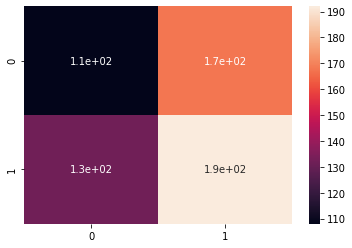

In [ ]:
### showing the confusion matrix for CDNN method

TEST_GEN_SIZE = min(30,config.TESTING_SET_SIZE)

get_test_set_ = create_generator_(TEST_GEN_SIZE, X_test[:config.TESTING_SET_SIZE], y_test[:config.TESTING_SET_SIZE])

pred_cdnn_method = model.predict_generator(get_test_set_, steps=config.TESTING_SET_SIZE//TEST_GEN_SIZE)
pred_cdnn_method_ = np.argmax(pred_cdnn_method, axis=1)

conf_mat = confusion_matrix(y_test[:config.TESTING_SET_SIZE],
                            pred_cdnn_method_)
sns.heatmap(conf_mat, annot=True)